## US Hit Streaming Songs Project - Data Analysis

The following Jupyter Notebook models the data collected and analyzed in the previous sections of this project. 

To start, we import necessary tools and the data collected previously. 

In [1]:
#for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#to remove the limits on a dataframe's columns displayed
pd.set_option('display.max_columns', None)

#to access google sheets with python
import gspread
from google.oauth2 import service_account
from oauth2client.service_account import ServiceAccountCredentials

#for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import spreadsheet service account
sa = gspread.service_account(filename="gspread_service_account.json")

#sheet
sh = sa.open("HITS Streaming Songs")

#worksheet
wks = sh.worksheet("DF to Gspread")

#uses all values in the worksheet for the data frame
gsheets_df_updated = pd.DataFrame(wks.get_all_values())

header = gsheets_df_updated.iloc[0] #isolate first row as header
gsheets_df_updated = gsheets_df_updated[1:] #get rid of header in original df
gsheets_df_updated.columns = header

#set 'index' as index
gsheets_df_updated = gsheets_df_updated.set_index('index')

#convert index from string to int
gsheets_df_updated.index = gsheets_df_updated.index.astype(int)

#turn peak_date strings to date format
gsheets_df_updated['peak_date'] = pd.to_datetime(gsheets_df_updated['peak_date'])
gsheets_df_updated['release_date'] = pd.to_datetime(gsheets_df_updated['release_date'])

#change the following columns to int/float/boolean format
gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'] = gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'].astype(int)
gsheets_df_updated.loc[:,'length':'valence'] = gsheets_df_updated.loc[:,'length':'valence'].astype(float)
gsheets_df_updated['explicit'] = gsheets_df_updated['explicit'].apply(eval)

#drop christmas songs
gsheets_df_updated.drop(gsheets_df_updated[gsheets_df_updated['holiday_music']==1].index,inplace=True)
gsheets_df_updated.reset_index(drop=True, inplace=True)

#drop unnessesary columns
cols_to_drop = list(gsheets_df_updated.iloc[:,5:-15].columns)
cols_to_drop.extend(['popularity','key','mode','explicit'])
gsheets_df_updated.drop(cols_to_drop, axis=1, inplace=True)

gsheets_df_updated

,title,artist,album,peak_date,streams_2017_to_present,length,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence
0,Closer,The Chainsmokers,Closer,2016-09-09,5528407,244960.0,0.414000,0.748,0.524,0.000000,0.1110,-5.599,0.0338,95.010,4.0,0.661
1,Fake Love,Drake,More Life,2016-11-04,31271140,210937.0,0.105000,0.928,0.481,0.000000,0.1760,-9.350,0.2870,134.007,4.0,0.613
2,Starboy,The Weeknd,Starboy,2016-11-25,5225061,230453.0,0.141000,0.679,0.587,0.000006,0.1370,-7.015,0.2760,186.003,4.0,0.486
3,Reminder,The Weeknd,Starboy,2016-11-25,5229932,218880.0,0.142000,0.706,0.505,0.000000,0.1640,-6.923,0.1930,160.053,4.0,0.388
4,Both (feat. Drake),Gucci Mane,The Return of East Atlanta Santa,2016-12-16,23375700,190311.0,0.119000,0.850,0.405,0.000118,0.0707,-7.509,0.2250,139.976,4.0,0.344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,Down Hill,Drake,"Honestly, Nevermind",2022-06-17,10140085,250864.0,0.965000,0.718,0.319,0.000360,0.0895,-11.261,0.0435,109.994,4.0,0.639
2106,The Kind of Love We Make,Luke Combs,Growin' Up,2022-06-17,9097056,224426.0,0.022600,0.608,0.745,0.000006,0.0942,-4.130,0.0277,102.025,4.0,0.464
2107,Tie That Binds,Drake,"Honestly, Nevermind",2022-06-17,8688133,336005.0,0.017600,0.775,0.688,0.091700,0.1080,-10.912,0.0593,120.017,4.0,0.284
2108,U-Digg (feat. 42 Dugg & Veeze),Lil Baby,U-Digg (feat. 42 Dugg & Veeze),2022-06-17,8150009,235500.0,0.002530,0.824,0.583,0.000000,0.2660,-6.537,0.1470,147.496,4.0,0.154


## K Means Clustering

To understand what styles of music the general public listens to on streaming, we can cluster songs together based on common characteristics. 

For this project, K-Means Cluster is to be used. For an overview of the K-means cluster technique, view this YouTube video: https://www.youtube.com/watch?v=4b5d3muPQmA.

To ensure all variables remain in the same scale, standardizing the data is necessary. The following standardizes 5 key variables from our data. From there, we use the elbow method technique to figure out how much k (k meaning the number of clusters we want) is necessary. In the elbow method, we graph the effects of different values for k (from 1 to 10) and determine the optimal k based on the point where rate of change of the Sum of Squared Distances decreases from more a steep decline to a smoother decline. In this case, the optimal k is recommended to be 4. 

In [2]:
#isolate variables to cluster
var_to_cluster = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'speechiness']
to_cluster = gsheets_df_updated[var_to_cluster]

#standardize the data
X = np.array(to_cluster)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


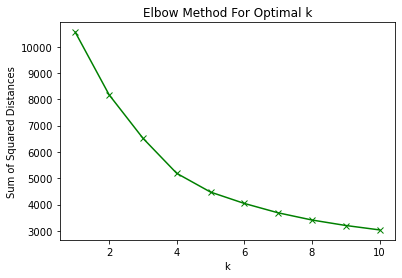

In [3]:
sum_squared_distances = []
K = range(1, 11)

#plot k for each value of K
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=1)
    km = km.fit(X)
    sum_squared_distances.append(km.inertia_)
plt.plot(K, sum_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [4]:
#based on the elbow method, let's choose 4 clusters and fit it into the model!
num_clusters = 4
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=10000, init='k-means++', random_state=1).fit(X)


## Cluster Visualization and Principle Component Analysis

Since our data is in 5 dimensions, we cannot visualize it. However, using principle component analysis, we can transform our 5-Dimensional data to 3-D data (or lower). It does not delete columns from our data. For an overview of the process behind this linear algebra concept view this video: https://www.youtube.com/watch?v=4b5d3muPQmA. Once the dimensions are reduced, we can visualize our data. 

In [5]:
#reduce the dimensions to 3 components
pca = PCA(n_components=3, random_state=1)
pca_results = pca.fit_transform(X)

In [6]:
#view how much of the data is explained by the Principle Component Analysis
print("Reducing our data from 5 dimensions to 3 preserves", (round(pca.explained_variance_ratio_.sum(),4)*100), "percent of our data.")
print("The following array tells us how much each PCA component makes up that", (round(pca.explained_variance_ratio_.sum(),4)*100), "percent")
pca.explained_variance_ratio_.cumsum()

Reducing our data from 5 dimensions to 3 preserves 74.48 percent of our data.
The following array tells us how much each PCA component makes up that 74.48 percent


array([0.34472699, 0.55463335, 0.74479207])

In [7]:
#prepare data for a scree plot (plots the eigenvalues of PCAs)
df_scree_plot = pd.DataFrame({'Component': ['1','2','3'],'Indivual':pca.explained_variance_ratio_})
df_scree_plot['cum_sum'] = df_scree_plot['Indivual'].cumsum()
df_scree_plot

,Component,Indivual,cum_sum
0,1,0.344727,0.344727
1,2,0.209906,0.554633
2,3,0.190159,0.744792


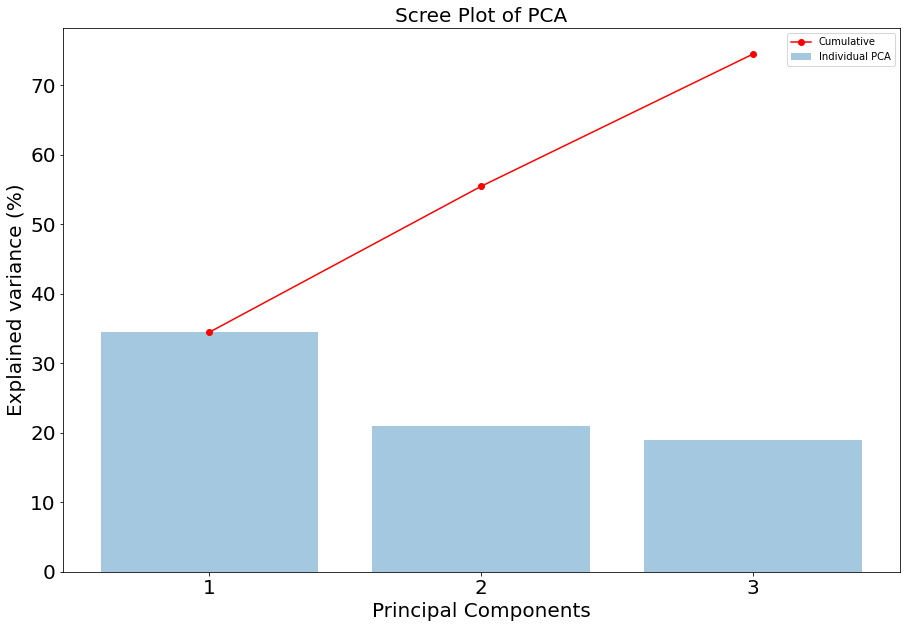

In [8]:
#create a scree plot 
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual PCA', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='red', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=20)
ax.set_yticklabels(range(0,90,10), fontsize=20)

plt.title('Scree Plot of PCA', fontsize=20)
plt.ylabel('Explained variance (%)', fontsize=20)
plt.xlabel('Principal Components', fontsize=20)
plt.legend()
plt.show()

Now, that the dimensions of our data are reduced thanks to PCA, graph the data! 

For this, we utilize both 2-D and 3-D models!

In [9]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3']
df_pca['label'] = kmeanModel.labels_
df_pca.head()

,PC1,PC2,PC3,label
0,0.872722,-0.121601,-0.167327,0
1,-0.888829,1.630918,0.006460,2
2,-0.354070,0.430162,-0.209555,2
3,0.018158,0.409895,-0.146515,0
4,-0.220245,1.368366,-0.082942,2


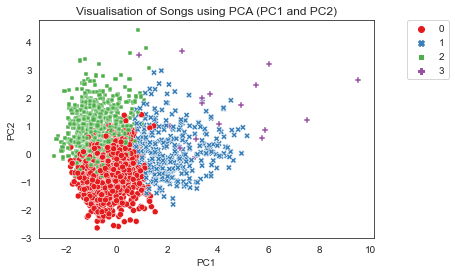

In [10]:
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA (PC1 and PC2)')
plt.show()

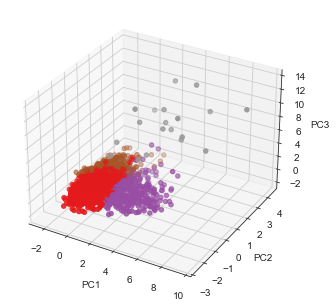

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
           c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

As noted in the two graphs above, a huge chunk of songs share the same characteristics. So much that it could also be reasonable to create two clusters for the hit songs data collected (one mega cluster and another smaller one for outliers). However, using the following graphs, we can conclude that the four clusters are still distinguishable in their own ways. 

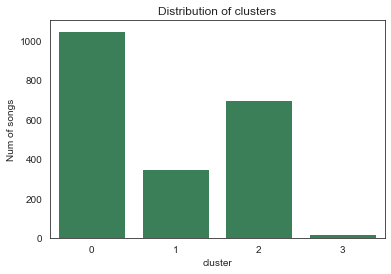

In [12]:
# assign label to recent dataframe
gsheets_df_updated.loc[:,'cluster'] = kmeanModel.labels_
df_cluster_size = gsheets_df_updated.groupby('cluster').size().reset_index(name='Num of songs')
df_cluster_size
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')
plt.title('Distribution of clusters')
plt.show()

## Profiling Clusters

In order to understand how the clusters are different, we must create the following visualization: 

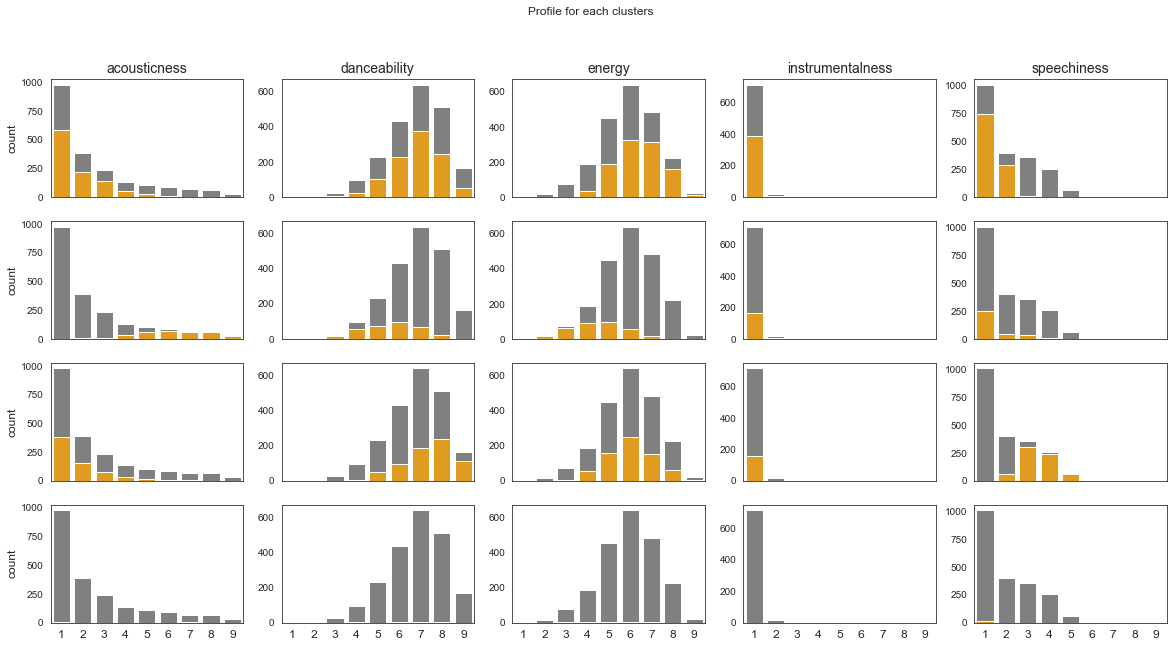

In [13]:
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(var_to_cluster)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(gsheets_df_updated['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster]
    col = 0
    
    for feature in var_to_cluster:
#         create binned count for all recent df and clustered df
        rec_grp = gsheets_df_updated.groupby(pd.cut(gsheets_df_updated[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='orange', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')

    
plt.show()

In [14]:
# calculate mean of each variable
radar_col = var_to_cluster + ['cluster']

# feature average for each cluster as a radar chart
df_radar = gsheets_df_updated[radar_col]
df_radar = df_radar.groupby('cluster').mean().reset_index()
df_radar

,cluster,acousticness,danceability,energy,instrumentalness,speechiness
0,0,0.134502,0.700968,0.653388,0.002422,0.089245
1,1,0.628004,0.570678,0.436878,0.008384,0.104833
2,2,0.138562,0.758583,0.612191,0.001315,0.332193
3,3,0.423259,0.602632,0.457463,0.582474,0.091953


As noted from the visualization and the graph above, the clusters can be categorized with the following descriptions: 

* dancy/energetic with more speechiness
* dancy/energetic with less speechiness
* acoustic/acoustic-leaning
* higher-than-normal instrumentality

From here, we can create a spider chart to show how each cluster's mean characteristics look like.

In [15]:
from math import pi, ceil

# radar chart
def make_spider(row, title, color, df, num_clusters):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

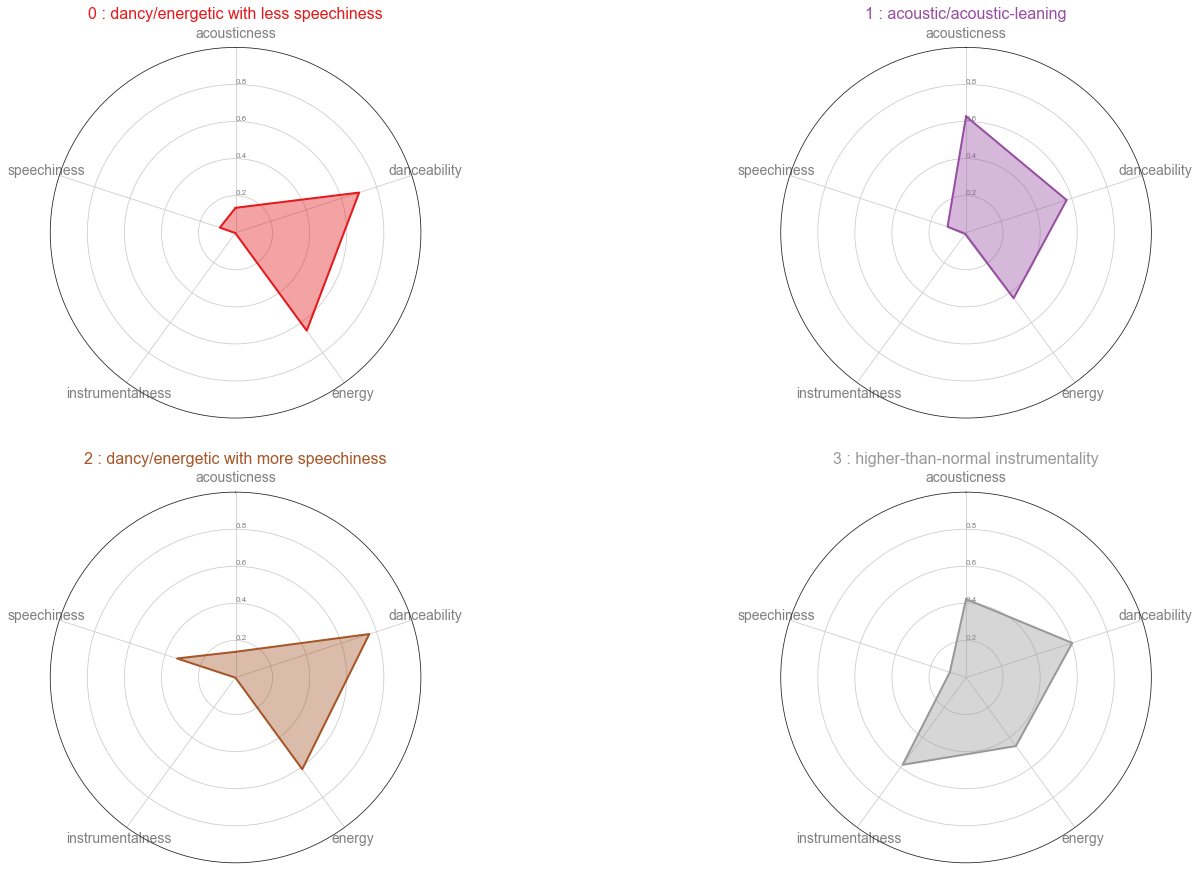

In [16]:
#list of titles for each cluster
title_list = ['dancy/energetic with less speechiness', 'acoustic/acoustic-leaning', 'dancy/energetic with more speechiness', 'higher-than-normal instrumentality']

# create figure
plt.figure(figsize=(24,15))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))

for row in range(0, len(df_radar.index)):
    make_spider(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), df=df_radar, num_clusters=len(df_radar.index))





## Randomly sampling songs from each cluster

From cluster 0: dancy/energetic with less speechiness

In [17]:
cluster_num = 0
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)


,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
1964,Sometimes,Juice WRLD,Fighting Demons (Deluxe),7527052,0.06090,0.674,0.580,0.000000,0.0311
778,I THINK,"Tyler, The Creator",IGOR,21010030,0.00881,0.826,0.579,0.000000,0.0801
392,Ghost Town,Kanye West,ye,42489554,0.09690,0.573,0.545,0.000000,0.0288
579,MIA,Bad Bunny,X 100PRE,139690554,0.01420,0.816,0.538,0.000496,0.0617
992,Falling,Trevor Daniel,Nicotine,346800399,0.12300,0.785,0.431,0.000000,0.0364


From cluster 1: acoustic/acoustic-leaning

In [18]:
cluster_num = 1
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)


,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
921,Playing Games (with Bryson Tiller) - Extended ...,Summer Walker,Over It,146018247,0.603,0.726,0.408,0.000000,0.0614
1941,I’m Tired (with Zendaya) - Bonus Track,Labrinth,EUPHORIA SEASON 2 OFFICIAL SCORE (FROM THE HBO...,13063454,0.651,0.375,0.133,0.000000,0.0352
313,Try Me,The Weeknd,"My Dear Melancholy,",43744569,0.596,0.456,0.679,0.000573,0.0640
1450,dorothea,Taylor Swift,evermore,11912197,0.696,0.605,0.488,0.000000,0.0264
1987,Something in the Orange,Zach Bryan,Something in the Orange,80192570,0.555,0.369,0.192,0.000008,0.0400


From cluster 2: dancy/energetic with more speechiness

In [19]:
cluster_num = 2
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)

,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
1898,livin wild,Gunna,DS4EVER,9064087,0.0220,0.748,0.607,0.000000,0.212
1491,GNF (OKOKOK),Polo G,Hall of Fame,7193735,0.6170,0.783,0.662,0.000000,0.409
1794,Rich Nigga Shit (with Juice WRLD),Young Thug,Punk,6685294,0.0270,0.849,0.479,0.000000,0.239
1921,Don't Play That,King Von,What It Means To Be King,31658478,0.0748,0.947,0.605,0.000008,0.346
668,Envy Me,Calboy,Wildboy,240173966,0.2340,0.740,0.488,0.000000,0.270


From cluster 3: higher-than-normal instrumentality

In [20]:
cluster_num = 3
df_cluster = gsheets_df_updated[gsheets_df_updated['cluster'] == cluster_num]
df_cluster.loc[:,['title','artist','album','streams_2017_to_present','acousticness',
            'danceability','energy','instrumentalness','speechiness']].sample(5)

,title,artist,album,streams_2017_to_present,acousticness,danceability,energy,instrumentalness,speechiness
369,Jonestown (Interlude),Post Malone,beerbongs & bentleys,12933765,0.75500,0.380,0.454,0.623,0.0362
1662,NDA,Billie Eilish,Happier Than Ever,9559632,0.34100,0.765,0.373,0.525,0.0713
988,everything i wanted,Billie Eilish,everything i wanted,247555307,0.90200,0.704,0.225,0.657,0.0994
206,Rap Saved Me (feat. Quavo),Metro Boomin,Without Warning,5930513,0.00525,0.845,0.399,0.741,0.3120
24,Get It Together,Drake,More Life,5211043,0.09450,0.781,0.721,0.391,0.0514


## Conclusion

After concluding this project, it is safe to say characterstics of popular music since 2017 have changed in some ways (for more information please reference the part 2 of this project)

In terms of the clustering models, 4 main clusters were found. Many of the clusters shared similar characteristics, with a notable presence of danceability and energy. Instrumentalness and acousticness set apart many songs from the others. 

Overall, it would be interesting to see if the recent rise in house/dance music tracks in June 2022 (thanks to Drake and Beyonce) have a lasting impact on popular music throughout the next several months! This could cause more songs to land in cluster_num 3 (which hosts songs with higher-than-usual instrumentalness). 